# BHPToolkit Spring 2020 Workshop: EMRISur1dq1e4 Proejct Tutorial

Some portions of this notebook are also found in the notebook
[EMRISur1dq1e4.ipynb](https://github.com/BlackHolePerturbationToolkit/EMRISurrogate/blob/master/EMRISur1dq1e4.ipynb). The waveform model is described in [arXiv:1910.10473](https://arxiv.org/abs/1910.10473).

EMRISur1dq1e4 is a surrogate gravitational-waveform model for non-spinning black hole binary systems with mass-ratios varying from 3 to $10^4$. This surrogate model is trained on waveform data generated by point-particle black hole perturbation theory (ppBHPT), with the total mass rescaling paramter tuned to NR simulations according to the paper's Eq. 4. Available modes are  $\{(2,2), (2,1), (3,3), (3,2), (3,1), (4,4), (4,3), (4,2), (5,5), (5,4), (5,3)\}$. The $m<0$ modes can be deduced from the m>0 modes due to symmetry of the system about the orbital plane. 

**NOTE**: This notebook rquires the file emri_sur_load.py and EMRISur1dq1e4.h5 datafile in the same directory for waveform generation

 # Setup
 
 1. You should now have the programs git and Jupyter as well as the Python packages scipy, h5py, and hashlib
 2. clone the EMRISurrogate code and this tutorial
 
 ```shell
 >>> git clone https://github.com/BlackHolePerturbationToolkit/EMRISurrogate.git
 >>> cd EMRISurrogate    # move into the new directory
 >>> jupyter notebook BHPToolkit_Spring2020_Tutorial.ipynb   # launch this tutorial
 ```

(no-git fallback plan: download the zip file from https://github.com/BlackHolePerturbationToolkit/EMRISurrogate)

In [2]:
# If your setup is correct, then this block of code should execute...

import matplotlib.pyplot as plt
import numpy as np
import hashlib
import h5py

# Lesson 1: The data

Surrogate models are numerical models. They require code *and* data

The EMRI surrogate model's data is [hosted on zenodo](https://zenodo.org/record/3612600#.XsoAP3VKg5k).

Our first task is to download the data:

```shell
>>> wget https://zenodo.org/record/3612600/files/EMRISur1dq1e4.h5
```

or click the "download" button and move the file to the same folder as this notebook.

## Make sure your data is at the latest version


The data file has a unique hash, which from zenodo is d145958484738e0c7292e084a66a96fa. 

If the surrogate model is updated then EMRISur1dq1e4.h5 will be replaced with a newer file. 

The [EMRI surrogate code](https://github.com/BlackHolePerturbationToolkit/EMRISurrogate/blob/master/emri_sur_load.py#L48) checks that your local h5 file's hash matches the most recent version.

<br>

<img src="hash_check.png" width="940" />

In [20]:
# data integrity: lets check that your file's hash is correct
# Current hash: d145958484738e0c7292e084a66a96fa

def md5(fname):
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

print( md5('EMRISur1dq1e4.h5') )

d145958484738e0c7292e084a66a96fa


In [19]:
# now import the some functions to help with evaluating the model
# This step requires that you've cloaned the git 
# project EMRISurrogate and have the data file listed above

import emri_sur_load as emriSur

## Data file's structure

Recall that the full surrogate model is 

\begin{align}
h_{\tt S}(t,\theta,\phi;q) & = \sum_{\ell,m} h_{\tt S}^{\ell,m}(t;q) {}_{-2}Y_{\ell m} (\theta,\phi) \\
h_{\tt S}^{\ell,m}(t;q) & = A_{\tt S}^{\ell,m}(t;q) \exp(- \mathrm{i} \phi_{\tt S}^{\ell,m}(t;q)) \,,
\end{align}
and we build models for $A_{\tt S}^{\ell,m}$, $\phi_{\tt S}^{\ell,m}$. Each $A_{\tt S}^{\ell,m}$ and $\phi_{\tt S}^{\ell,m}$ is represented as an empirical interpolant (EI) with parametric fits that the time nodes.

Lets check that our data file matches this structure.

In [8]:
# Each mode is a separate surrogate model

# open the file
fp = h5py.File("EMRISur1dq1e4.h5","r")

# inspect the data groups
print("EMRI surrogate data groups: ",fp.keys() )
print("\n\n" )

# grab the 22 mode data group
sur_22 = fp["l2_m2"]

# inspect (2,2)-mode's data groups
print("22 mode surrogate data groups: ",sur_22.keys() )

EMRI surrogate data groups:  <KeysViewHDF5 ['l2_m1', 'l2_m2', 'l3_m1', 'l3_m2', 'l3_m3', 'l4_m2', 'l4_m3', 'l4_m4', 'l5_m3', 'l5_m4', 'l5_m5']>



22 mode surrogate data groups:  <KeysViewHDF5 ['B', 'B_phase', 'degree', 'eim_indicies', 'eim_indicies_phase', 'fit_max', 'fit_min', 'fit_type_amp', 'fit_type_norm', 'fit_type_phase', 'fitparams_amp', 'fitparams_phase', 'n_spline_knots', 'parameterization', 'spline_knots', 'surrogate_mode_type', 'times']>


## The surrogate model for $A^{22}(t;q)$

Do to an unfortunate choice made a long time ago, the quantitites without any extra postfix denote ampitude date: B_phase is the basis for the phase, while B is the basis for the amplitude. So we have the following data for the 22 mode's amplitude:


### Information about the amplitude's parametric dependence
* 'fit_type_amp': model for the amplitude's dependence with mass ratio
* 'parameterization': how we parameterize the amplitude data
* 'fit_max' / 'fit_min' : smallest / largest values of parametric domain
* 'n_spline_knots': number of spline knots
* 'spline_knots':  location of spline knots
* 'fitparams_amp': spline parameters 
* 'degree': degree of the spline used


### Information about the amplitude's temporal dependence
* 'B': basis 
* 'eim_indicies': location of empirical interpolation nodes
* 'times': temporal domain on which the amplitude is modeled 

The model is given by

\begin{align}
A_{\tt S}^{22}(t;q) = \sum_{i=0}^9 A(T_i^\mathrm{EIM};q) B_i(t) \,,
\end{align}

where $B_i(t)$ is the $i^{th}$ basis function and $T_i^\mathrm{EIM}$ is the $i^{th}$ empirical interpolation time node. We see that, $A(T_i^\mathrm{EIM};q)$ are the coefficients defining the amplitude's expansion in terms of the basis. 

Data found in "Information about the amplitude's parametric dependence" is used to model each coefficient, $A(T_i^\mathrm{EIM};q)$, over the paramter space.

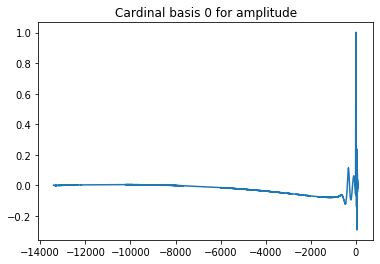

In [9]:
# Lets inspect the basis for the 22 mode's amplitude
# Because each basis is a linear combination of amplitudes, 
# the basis will look kinda like an waveform amplitude.

# The basis will not look like any standard function (polynomials, sine/cosine, etc...)

### plot the ith cardinal basis function  ###
i = 0
times = sur_22['times']
B     = sur_22['B']

plt.figure(1)
plt.plot(times,B[:,i])
plt.title('Cardinal basis %i for amplitude'%i)

plt.show()

Text(0.5, 1.0, 'EI time node locations')

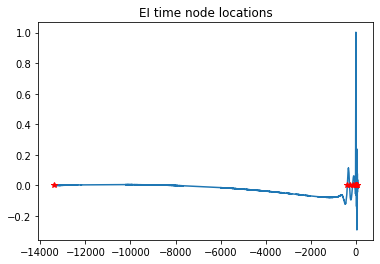

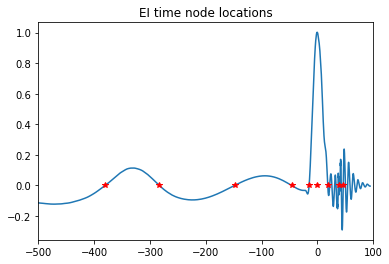

In [21]:
# Lets inspect the empirical interpolation time nodes for the 
# 22 mode's amplitude.

# These nodes are used to define the interpolation problem: the 
# surrogate interpolates the waveform training data at these times.

# The time nodes will automatically be placed in regions of higher
# activitiy. Unlike uniform, Chebyshev, or other common time nodes
# the EI nodes are adaptive to the problem

### plot the location of all emprical interpolation points  ###
plt.figure(2)
eim_indicies = sur_22['eim_indicies'][:]
plt.plot(times,B[:,0]) # 0^th basis function
plt.plot(times[np.sort(eim_indicies)],np.zeros_like(eim_indicies),'r*') 
plt.title('EI time node locations')

plt.figure(3)
eim_indicies = sur_22['eim_indicies'][:]
plt.plot(times,B[:,0]) # 0^th basis function
plt.plot(times[np.sort(eim_indicies)],np.zeros_like(eim_indicies),'r*') 
plt.xlim([-500,100])
plt.title('EI time node locations')

# Lesson 2: Evaluating the model

Input: mass ratio q, and (optionally) modes to generate = [(2,1),(2,2),(3,1),(3,2),(3,3),(4,2),(4,3),(4,4),(5,3),(5,4),(5,5)]

Output: dictionary of modes, $h_{\tt S}^{\ell,m}(t;q)$

\begin{align}
h_{\tt S}(t,\theta,\phi;q) & = \sum_{\ell,m} h_{\tt S}^{\ell,m}(t;q) {}_{-2}Y_{\ell m} (\theta,\phi)
\end{align}


Both h and t are in geometric units

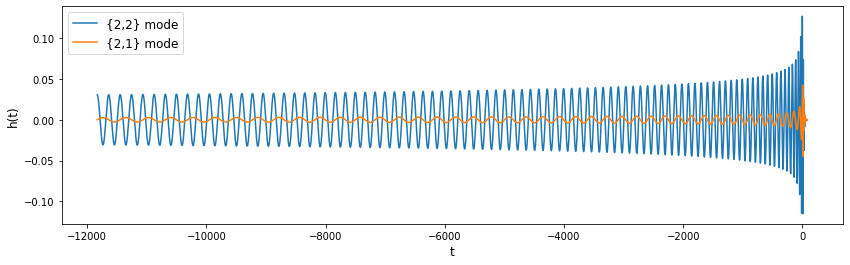

In [16]:
q = 10.0 # mass ratio
time, h = emriSur.generate_surrogate(q) # h is a dictionary with modes as its key

# h is a dictionary of modes 
h_22=h[(2,2)]
h_21=h[(2,1)]

plt.figure(figsize=(14,4))
plt.plot(time,np.real(h_22),label='{2,2} mode')
plt.plot(time,np.real(h_21),label='{2,1} mode')
plt.xlabel('t',fontsize=12)
plt.ylabel('h(t)',fontsize=12)
plt.legend(fontsize=12)
#plt.savefig('emri_sur_q_%f.png'%q)
plt.show()

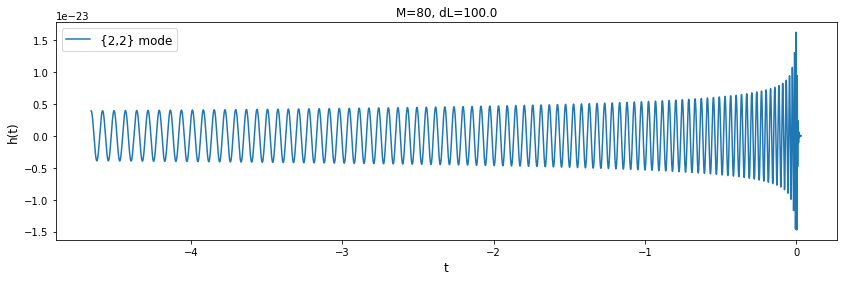

In [17]:
# waveform in mks units (roughly what the detector would observe)

G=6.674*1e-11
MSUN_SI = 1.9885469549614615e+30
PC_SI = 3.085677581491367e+16
C_SI = 299792458.0

# values of M and dL
M=80.0*MSUN_SI
dL=100.0* PC_SI

# scaling of time and h(t)
time=time*(G*M/C_SI**3)
ht22=np.array(h[(2,2)])*(G*M/C_SI**3)/dL

plt.figure(figsize=(14,4))
plt.title('M=80, dL=100.0')
plt.plot(time,np.real(ht22),label='{2,2} mode')
plt.xlabel('t',fontsize=12)
plt.ylabel('h(t)',fontsize=12)
plt.legend(fontsize=12)
#plt.savefig('emri_sur_q_%f_physical.png'%q)
plt.show()

# Lesson 3: EMRI surrogate vs output from the Teukolsky solver

Our underlying model (denoted $h^{\ell,m}_{\tt S}$ below) is for the output of the Teukolsky solver for point-particle perturbation theory. 

However, the EMRI surrogate model (denoted $h^{\ell,m}_{\tt S, \alpha}$ below) is calibrated to numerical relativity waveforms at comparable mass binaries with a single parameter $\alpha$:

\begin{align*}
h^{\ell,m}_{\tt S, \alpha}(t ; q)= {\alpha} h^{\ell,m}_{\tt S}\left( t \alpha;q \right) \,,
\end{align*}

Which is enacted in emri_sur_load.py file as shown below:

<img src="Alpha_scaling_in_code.png" width="840" />

### To generate output from the Teukolsky solver (no NR calibration) simply set $\alpha = 1$ in lines 110 and 118 

(Issue tracker: feature request to allow for this without needing to modify the code)

<img src="Alpha_scaling_in_code.png" width="840" />

# Summary 

1. To understand how to use the EMRI surrogate model, please consult the Jupyter noteobook found with the [EMRISur1dq1e4 proejct](https://github.com/BlackHolePerturbationToolkit/EMRISurrogate/blob/master/EMRISur1dq1e4.ipynb) in addition to this notebook. 

2. Future EMRI surrogate models or improvements will be added here.

3. If you find any issues or have suggestions please open up an issue (or, better yet, a pull request!)

<br>

<img src="Issue1.png" width="840" />